In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.signal import savgol_filter
from scipy import fftpack
from sklearn.preprocessing import MinMaxScaler
import time
import torch
import torch.nn as nn
import pickle
from os import path
from pandas.plotting import autocorrelation_plot
import sklearn as sk
from sklearn.decomposition import PCA
from matplotlib.ticker import MaxNLocator

import utilities as util
import models

In [3]:
params = {'id': 'autocorr',
          'path2data': '../data/ID02_1h.mat',
          # model parameters ------------------------
          'channel_size': 60,
          'hidden_size': 0,
          'lambda': 0.5,
          'non-linearity': 'tanh',
          'bias': False,
          # train parameters -------------------------
          'sample_size': 10000,
          'window_size': 10,
          'normalization': True,
          'epochs': 20,
          'lr_decay': 7}

train_set, test_set = util.data_loader(params=params, train_portion=1, windowing=False)

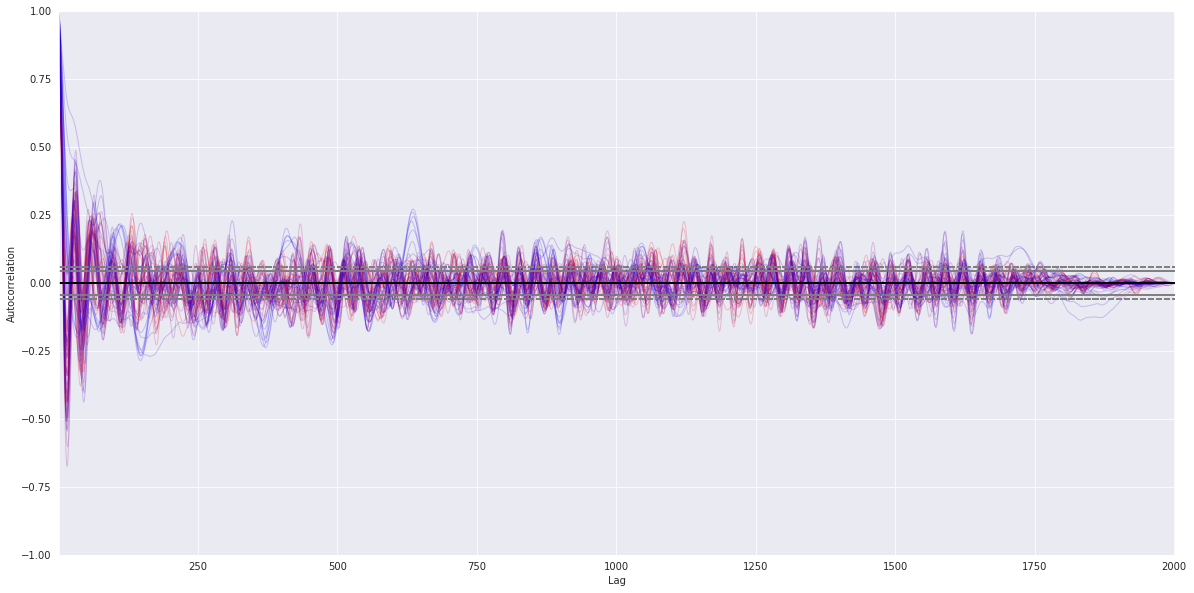

In [18]:
fs = 512
lag = 2000/fs

df = pd.DataFrame(train_set.numpy())
df['Time [s]'] = pd.Series([i/fs for i in range(df.shape[0])])
df.set_index('Time [s]', inplace=True)
#df[0][:50/512].plot()
sns.set_style('darkgrid')
plt.figure(figsize=(20,10))
for i in range(params['channel_size']):
    autocorrelation_plot(df[i][:lag], color=(1-i/params['channel_size'],0,i/params['channel_size']), alpha=.2, linewidth=1)

In [27]:
spect = np.zeros((10000, 60))
for i in range(params['channel_size']):
    spect[:, i] = np.abs(fftpack.fft(train_set[:, i].numpy()))
freq = fftpack.fftfreq(10000) * fs


Text(0, 0.5, 'Frequency Domain (Spectrum) Magnitude')

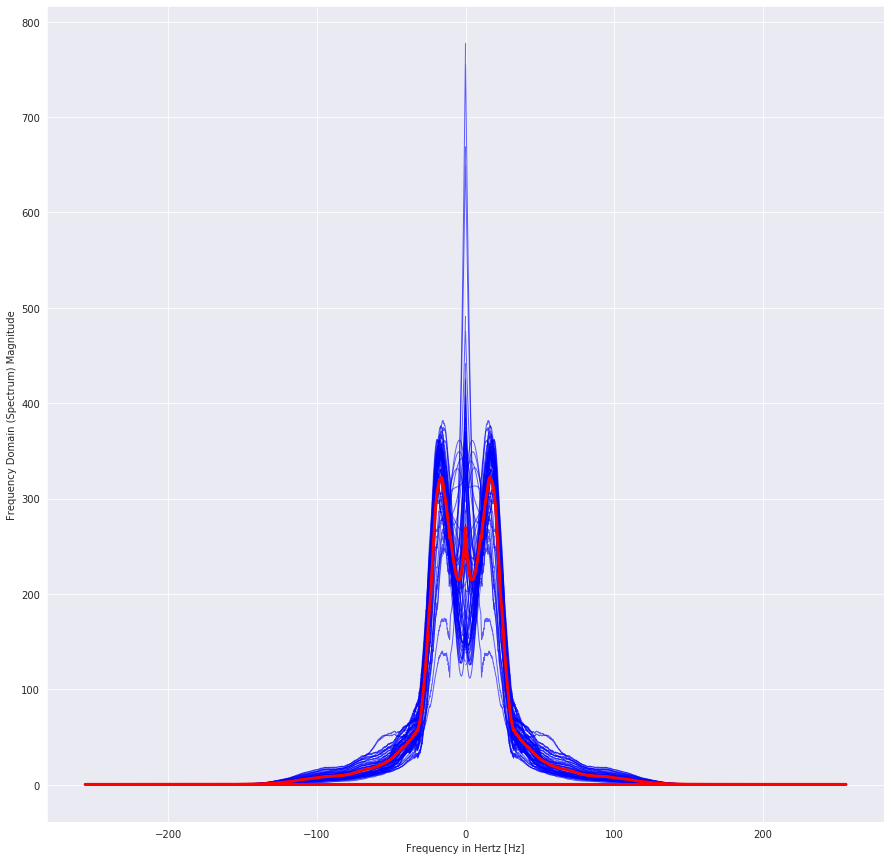

In [30]:
fig, ax = plt.subplots(figsize=(15,15))

for i in range(params['channel_size']):
    filt = savgol_filter(np.abs(spect[:,i]), 401, 3)
    ax.plot(freq, filt, color='blue', linewidth=1, alpha=.6)
filt = savgol_filter(np.mean(np.abs(spect), axis=1), 401, 3)
ax.plot(freq, filt, color='red', linewidth=3)
    #ax.plot(freq, np.abs(spect[:,i]), color='red', linewidth=2, alpha=.2)
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
#ax.set_xlim(-1, 250)
#ax.set_ylim(0, 2000)

In [4]:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''

    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

def autocorr2(x,lags):
    '''manualy compute, non partial'''

    mean=np.mean(x)
    var=np.var(x)
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]

    return  np.array(corr)

def autocorr3(x,lags):
    '''fft, pad 0s, non partial'''

    n=len(x)
    # pad 0s to 2n-1
    ext_size=2*n-1
    # nearest power of 2
    fsize=2**np.ceil(np.log2(ext_size)).astype('int')

    xp=x-np.mean(x)
    var=np.var(x)

    # do fft and ifft
    cf=np.fft.fft(xp,fsize)
    sf=cf.conjugate()*cf
    corr=np.fft.ifft(sf).real
    corr=corr/var/n

    return corr[:len(lags)]

In [4]:
lags = [i for i in range(1000)]
acf = []

for i in range(60):
    x = train_set[:,i].numpy()
    mean=np.mean(x)
    var=np.var(x)
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]
    acf.append(np.array(corr))

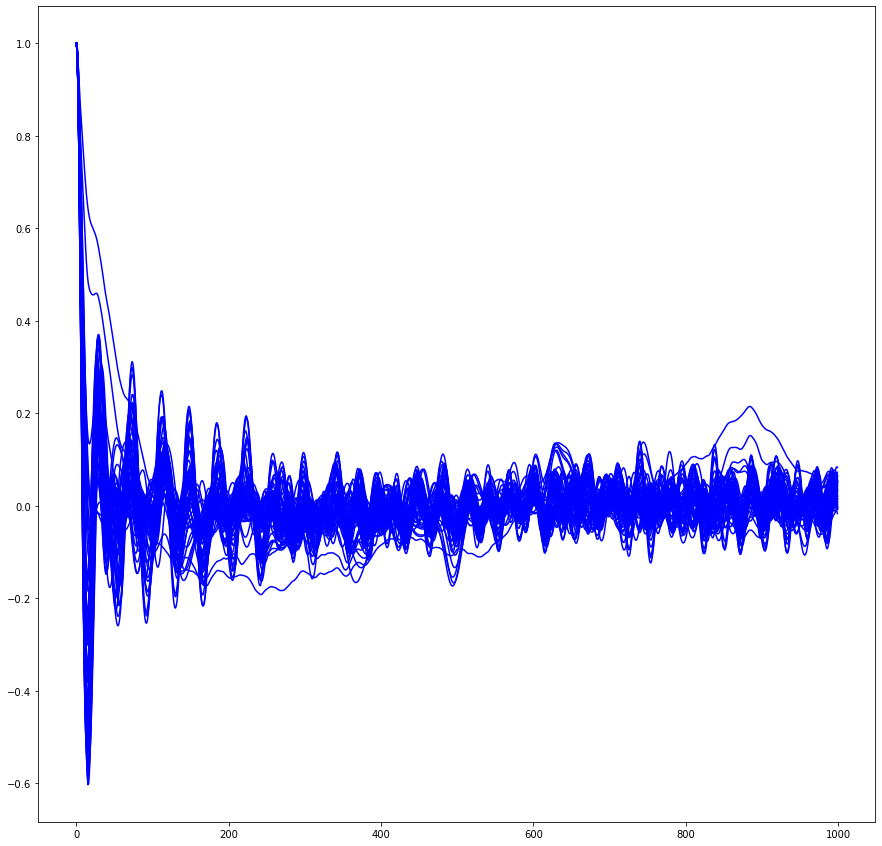

In [5]:
plt.figure(figsize=(15,15))

for i in range(60):
    plt.plot(acf[i], color='b')

ModuleNotFoundError: No module named 'statsmodels'

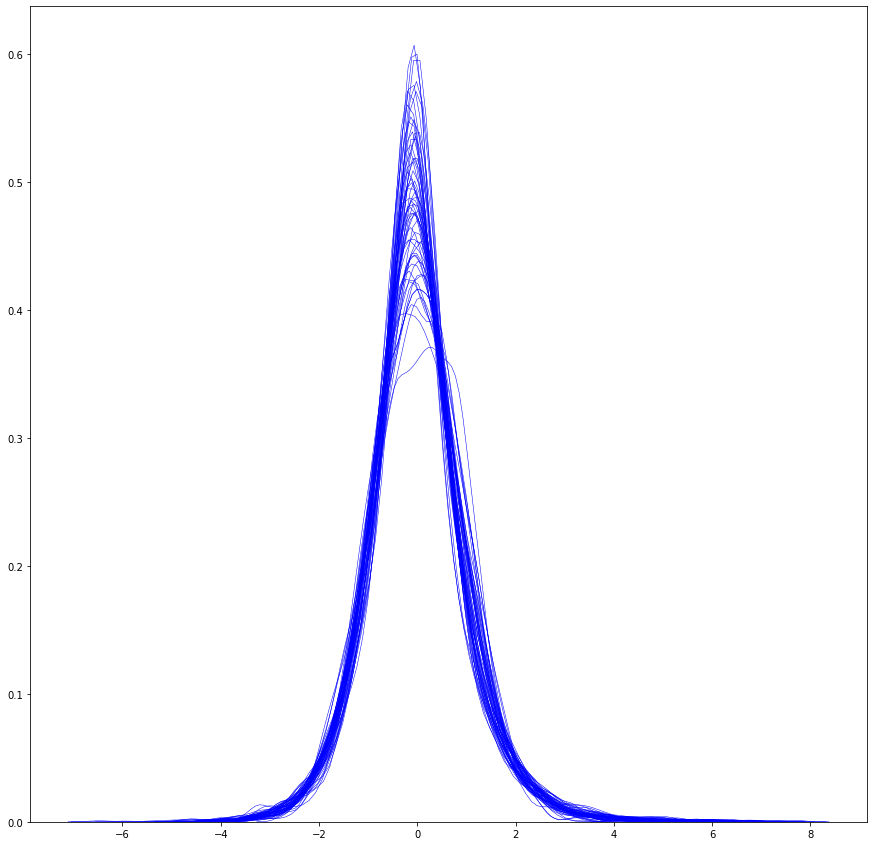

In [16]:
fig, ax = plt.subplots(figsize=(15,15))
x = train_set.numpy()
for i in range(params['channel_size']):
    sns.distplot(x[:,i], hist=False, ax=ax, color=(0,0,1), kde_kws=dict(linewidth=.5))
#sns.distplot(np.mean(x, axis=0), hist=False, ax=ax, color=(1,0,0), kde_kws=dict(linewidth=3))
#plt.xlim((-1, 1))
from statsmodels.tsa.stattools import adfuller
"""
result = adfuller(x)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
"""

(60, 12)


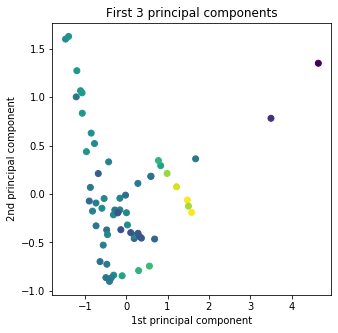

In [6]:
# Do PCA
pca = PCA(n_components=12)
pca_result = pca.fit_transform(np.array(acf))
print(pca_result.shape)

# Plot the 1st principal component aginst the 2nd and use the 3rd for color
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(pca_result[:, 0], pca_result[:, 1], c=pca_result[:, 2])
ax.set_xlabel('1st principal component')
ax.set_ylabel('2nd principal component')
ax.set_title('First 3 principal components')

plt.show()

In [7]:
pca_result.shape

(60, 12)

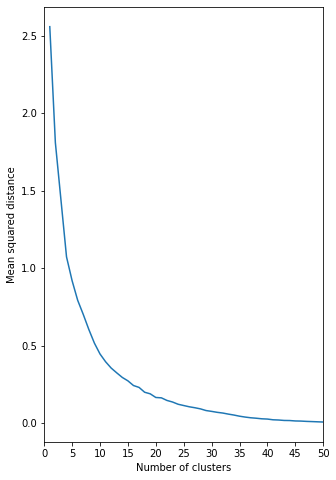

In [8]:
from sklearn.cluster import KMeans
ax = plt.figure(figsize=(5, 8)).gca()
max_n_clusters = 50
n_clusters = list(range(1, max_n_clusters + 1))
score = []
for i, val in enumerate(n_clusters):
    kmeans = KMeans(n_clusters=val)
    clusters = kmeans.fit(pca_result)
    score.append(clusters.inertia_/params['channel_size'])
plt.plot(n_clusters, score)
plt.xlabel('Number of clusters')
plt.ylabel('Mean squared distance')
plt.xlim((0, max_n_clusters))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))


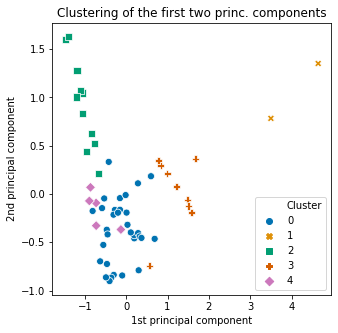

In [12]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters)
clusters = kmeans.fit(pca_result)

df = pd.DataFrame(pca_result)
df['Cluster'] = clusters.labels_

plt.figure(figsize=(5, 5))

sns.scatterplot(x=0, y=1, data=df, s=50, hue='Cluster', style='Cluster', palette='colorblind')
plt.xlabel('1st principal component')
plt.ylabel('2nd principal component')
plt.title('Clustering of the first two princ. components')
plt.show()


In [10]:
def all_indices(value, qlist):
    indices = []
    idx = -1
    while True:
        try:
            idx = qlist.index(value, idx+1)
            indices.append(idx)
        except ValueError:
            break
    return indices

print(all_indices(0, list(clusters.labels_)))
print(list(clusters.labels_))

[2, 20, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41]
[1, 1, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 1, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1]


In [13]:
X = np.array(acf).T
sample_size = X.shape[0]
node_size = X.shape[1]

df = pd.DataFrame()
df['sample'] = np.tile(np.arange(0, sample_size), node_size)
df['node'] = np.repeat(np.arange(0, node_size), sample_size)
df['cluster'] = np.repeat(list(clusters.labels_), sample_size)
df['value'] = X.T.flatten()

In [15]:
df.tail()

,sample,node,cluster,value
59995,995,59,0,0.007752
59996,996,59,0,0.009562
59997,997,59,0,0.010743
59998,998,59,0,0.010882
59999,999,59,0,0.009609


(-0.6, 0.6)

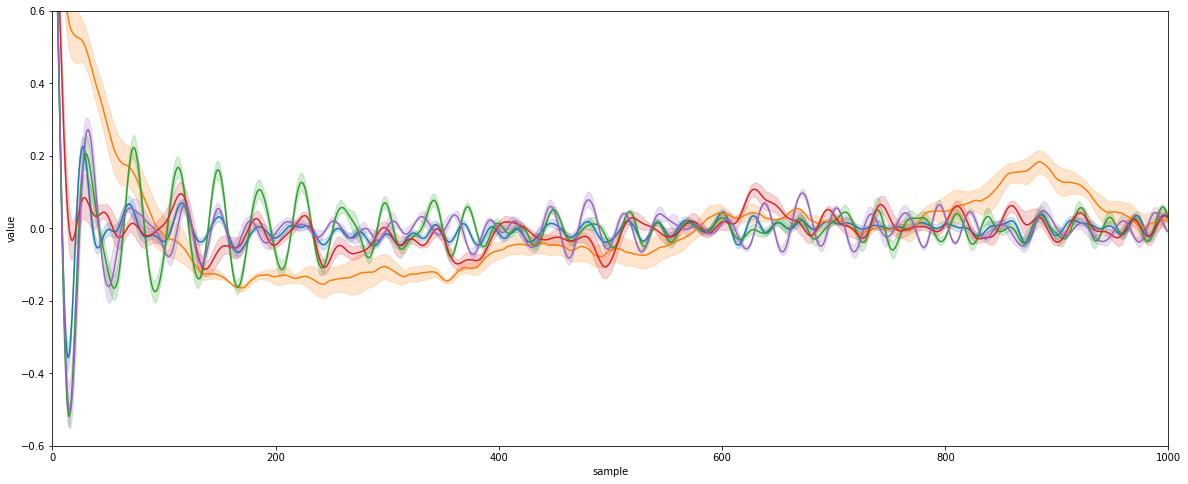

In [16]:
plt.figure(figsize=(20,8))
for i in range(n_clusters):
    sns.lineplot(x='sample', y='value', data=df.where(df['cluster']==i))
plt.xlim(0, 1000)
plt.ylim(-.6, .6)

(-0.6, 0.6)

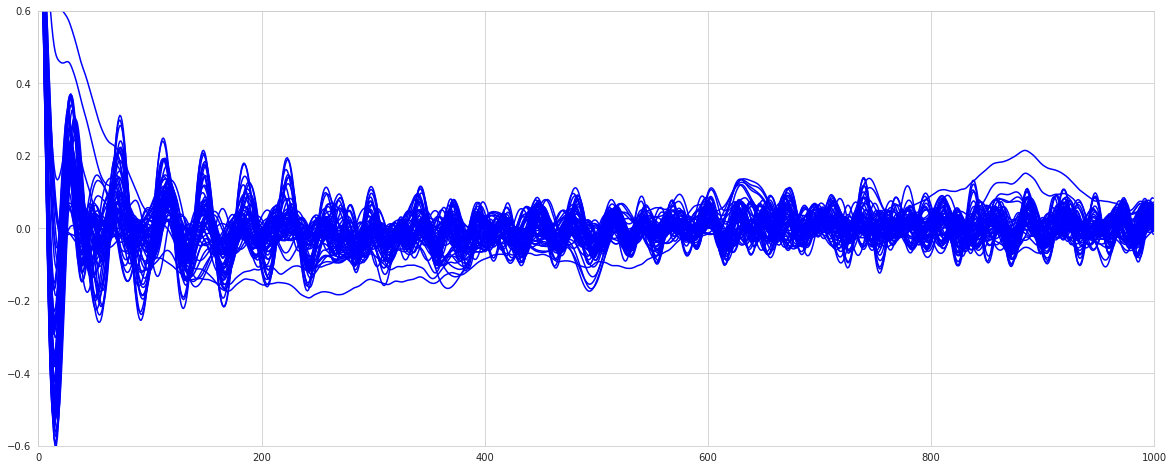

In [54]:
plt.figure(figsize=(20,8))
sns.set_style('whitegrid')
for i in range(60):
    plt.plot(acf[i], color='b')
plt.xlim(0, 1000)
plt.ylim(-.6, .6)